In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import sys
import halfspace.projections as hsp
import time

import halfspace.stress_comps_vectorized as scv

sys.path.append('/home/ubuntu/stress/aux_scripts/')
from stress_plots import rose, scatter_w_marginals

In [13]:
out_name = '../results/nepal_tect_posteriors.csv'
fault_file = '../data/fault_data/fault_pts_stresses.csv'

fd = pd.read_csv(fault_file, index_col=0)
fd.fault_name.fillna('nan', inplace=True)


fdf = fd[[False if 'aftershock' in fn else True for fn in fd.fault_name] ]

In [15]:
fdf.shape

(1251, 19)

In [16]:
fd.shape

(2056, 19)

In [17]:
fdf['ind'] = fdf.index.values.astype('float')

/home/ubuntu/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
fdf.head()

,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind,zz_stress,xy_stress,xz_stress,yz_stress,xx_stress,yy_stress,tau_dd,tau_ss,sig_nn,ind
46,187652.100681,3201695.699761,-900,19.761917,55,0.05,-90,nan,46,30,91.660655,-23.592039,7.047159,-15.262829,116.635841,116.559867,22.818001,-8.014952,107.406454,46
47,182389.018021,3189482.756855,-905,19.761917,55,0.05,-90,nan,47,30,76.353217,-26.335601,-1.674472,2.729693,112.519571,123.656915,24.610810,-20.692174,115.069749,47
48,177410.108366,3184445.612939,-952,19.761917,55,0.05,-90,nan,48,30,94.288301,-33.332509,0.691854,9.537297,112.488335,135.714470,18.885294,-32.397864,124.934737,48
49,173003.190810,3180027.682572,-1285,19.761917,55,0.05,-90,nan,49,30,112.830067,-32.452741,-4.658254,-3.281453,125.441811,117.593029,14.087774,-15.785102,137.625834,49
50,168449.167252,3177094.112030,-1284,19.761917,55,0.05,-90,nan,50,30,98.725853,-18.535620,10.384544,-18.818548,127.878486,116.612641,24.153216,-0.631182,110.175997,50


In [19]:
fdf.loc[fdf.rake==-90, 'slip_m'] = 0.05

fdf.head()

/home/ubuntu/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind,zz_stress,xy_stress,xz_stress,yz_stress,xx_stress,yy_stress,tau_dd,tau_ss,sig_nn,ind
46,187652.100681,3201695.699761,-900,19.761917,55,0.05,-90,nan,46,30,91.660655,-23.592039,7.047159,-15.262829,116.635841,116.559867,22.818001,-8.014952,107.406454,46
47,182389.018021,3189482.756855,-905,19.761917,55,0.05,-90,nan,47,30,76.353217,-26.335601,-1.674472,2.729693,112.519571,123.656915,24.610810,-20.692174,115.069749,47
48,177410.108366,3184445.612939,-952,19.761917,55,0.05,-90,nan,48,30,94.288301,-33.332509,0.691854,9.537297,112.488335,135.714470,18.885294,-32.397864,124.934737,48
49,173003.190810,3180027.682572,-1285,19.761917,55,0.05,-90,nan,49,30,112.830067,-32.452741,-4.658254,-3.281453,125.441811,117.593029,14.087774,-15.785102,137.625834,49
50,168449.167252,3177094.112030,-1284,19.761917,55,0.05,-90,nan,50,30,98.725853,-18.535620,10.384544,-18.818548,127.878486,116.612641,24.153216,-0.631182,110.175997,50


In [20]:
def cat_t_priors(num_pts, n_trials, s1_range, s3_range, theta_range, first_iter):
    
    t_priors = sample_T_priors(n_trials, s1_range, s3_range, theta_range)
    run_ind = np.arange(n_trials) + first_iter
    t_priors = np.hstack(( t_priors, run_ind.reshape([n_trials, 1]) ))
    t_priors = np.repeat(t_priors, num_pts, axis=0)
    
    t_prior_df = pd.DataFrame(t_priors, columns=['txx', 'tyy', 'txy', 'iter'])
    
    return t_prior_df
    
    
def sample_T_priors(n_trials, s1_range, s3_range, theta_range):
    s1s = np.random.uniform(s1_range[0], s1_range[1], n_trials)
    s3s = np.random.uniform(s3_range[0], s3_range[1], n_trials) * s1s
    thetas = np.random.uniform(theta_range[0], theta_range[1], n_trials)
    
    xxs = scv.xx_stress_from_s1_s3_theta(s1s, s3s, thetas)
    yys = scv.yy_stress_from_s1_s3_theta(s1s, s3s, thetas)
    xys = scv.xy_stress_from_s1_s3_theta(s1s, s3s, thetas)
    
    del s1s, s3s, thetas  # save some RAM (important for large n_trials)
    
    xxs = xxs.reshape([n_trials, 1])
    yys = yys.reshape([n_trials, 1])
    xys = xys.reshape([n_trials, 1])

    t_priors = np.concatenate((xxs, yys, xys), axis=1)
    
    return t_priors 


def make_mc_df(in_df, n_trials=1, s1_range=(0,2), s3_range=(-1,1), theta_range=(0, np.pi),
               first_iter=0):
    
    num_pts = len(in_df.index)
    
    important_cols = ['strike', 'dip', 'rake', 'depth', 'slip_m',
                      'xx_stress', 'yy_stress', 'zz_stress',
                      'xy_stress', 'xz_stress', 'yz_stress']
    
    mc_df = pd.DataFrame( np.tile(in_df[important_cols].values, [n_trials, 1]),
                         columns=important_cols)
    
    t_prior_df = cat_t_priors(num_pts, n_trials, s1_range, s3_range, 
                              theta_range, first_iter)
    
    mc_df = pd.concat((mc_df, t_prior_df), axis=1)
    
    del t_prior_df
    
    mc_df.rename(columns={'xx_stress':'mxx', 'yy_stress':'myy', 'zz_stress':'mzz',
                          'xy_stress':'mxy', 'xz_stress':'mxz', 'yz_stress':'myz'},
                 inplace=True)
    return mc_df


def get_total_stresses(mc_df, rho, g):
    
    mc_df['tau_s'] = scv.strike_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1)
    
    mc_df['tau_d'] = scv.dip_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1)
    
    mc_df['tau_rake'] = hsp.get_rake_from_shear_components(strike_shear=mc_df.tau_s,
                                                           dip_shear=mc_df.tau_d)
    
    mc_df['rake_misfit_rad'] = np.radians(scv.angle_difference(mc_df.rake,
                                                               mc_df.tau_rake,
                                                               return_abs=True))
    return mc_df

    
def do_stress_calcs(in_df, n_trials=1, s1_range=(0,3), s3_range=(-1,1), theta_range=(0, np.pi),
               first_iter=0, rho=2700, g=9.81, l_norm=1):
    
    mc_df = make_mc_df(in_df, n_trials=n_trials, s1_range=s1_range, s3_range=s3_range, 
                       theta_range=theta_range, first_iter=first_iter)
    
    mc_df = get_total_stresses(mc_df, rho, g)
    
    #calculate misfits
    sum_weights = np.sum(in_df.slip_m)
    #rake_err = np.pi/9
    kappa = 8.529
    
    mc_df['weighted_diff'] = mc_df.rake_misfit_rad * mc_df.slip_m
    mc_df['weighted_diff_sq'] = mc_df.weighted_diff**2
    
    iters = mc_df.groupby('iter')
    
    del mc_df
    
    l1_misfit = iters.weighted_diff.sum() / sum_weights
    l2_misfit = np.sqrt(iters.weighted_diff_sq.sum()) / sum_weights**2
    
    if l_norm==1:
        likelihood = np.exp(kappa * np.cos(l1_misfit) )
    elif l_norm==2:
        likelihood = np.exp(kappa * np.cos(l2_misfit) )
    
    like_df = pd.DataFrame(index=iters['iter'].mean(),
                           columns=['txx', 'tyy', 'txy', 'likelihood'])
    like_df['txx'] = iters.txx.mean()
    like_df['tyy'] = iters.tyy.mean()
    like_df['txy'] = iters.txy.mean()
    like_df['likelihood'] = likelihood
    
    return like_df

In [21]:
t_start = time.time()

np.random.seed(69)

n_mcs = 100000

trials_per_loop = 100

n_loops = int(n_mcs / trials_per_loop)

likes = {}

for i in range(n_loops):
    
    first_iter = i * trials_per_loop
    
    likes[i] = do_stress_calcs(fdf, n_trials=trials_per_loop, 
                               s1_range=(0,3), s3_range=(-1,1),
                               first_iter=first_iter, l_norm=1)
    if i % 100 == 0:
        print(i)
    
t_end = time.time()

print('done in', int((t_end - t_start) / 60 ), 'm')

0
100
200
300
400
500
600
700
800
900
done in 3 m


In [22]:
like_df = pd.concat([li for li in likes.values()])

In [23]:
like_df.describe()

,txx,tyy,txy,likelihood
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.747349,0.746514,-0.001077,326.428155
std,0.969525,0.969990,0.706835,474.743293
min,-2.856535,-2.965837,-2.914199,0.000448
25%,0.093974,0.094865,-0.283049,29.676733
50%,0.635346,0.634468,-0.000065,97.926722
75%,1.427298,1.427383,0.282021,389.576785
max,2.998208,2.997870,2.913789,1956.494869


In [24]:
like_df['rel_likelihood'] = like_df['likelihood'] / like_df.likelihood.max()

In [25]:
np.random.seed(1010)

rand_filter = np.random.uniform(size=n_mcs)

keeps = like_df[like_df.rel_likelihood > rand_filter]

In [26]:
keeps.describe()

,txx,tyy,txy,likelihood,rel_likelihood
count,16652.000000,16652.000000,16652.000000,16652.000000,16652.000000
mean,0.007303,0.811066,0.331851,1016.237274,0.519417
std,0.722083,0.781768,0.542317,568.126170,0.290380
min,-2.757840,-0.950963,-1.694281,1.937080,0.000990
25%,-0.230811,0.138440,-0.000745,512.141198,0.261765
50%,0.031372,0.543661,0.112575,1097.890744,0.561152
75%,0.216028,1.353714,0.568626,1522.040922,0.777943
max,2.976609,2.995744,2.874279,1956.494869,1.000000


In [27]:
def cart_stresses_to_eigs(xx=0., yy=0., xy=0.):
    
    T = hsp.make_xy_stress_tensor(xx, yy, xy)
    
    vals, vecs = hsp.sorted_eigens(T)
    
    s1, s3 = vals[1], vals[0]
    
    max_x = vecs[0,1] * s1
    max_y = vecs[1,1] * s1
    
    theta = hsp.angle_to_azimuth( np.arctan2(max_y, max_x))
    
    return s1, s3, theta

def pandas_car_to_eigs(row):
    s1, s3, theta = cart_stresses_to_eigs(row['txx'], row['tyy'], row['txy'])
    
    return pd.Series([s1, s3, theta], index=['s1', 's3', 'theta'])

In [28]:
keeps[['s1', 's3', 'theta']] = keeps.apply(pandas_car_to_eigs, axis=1)

/home/ubuntu/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


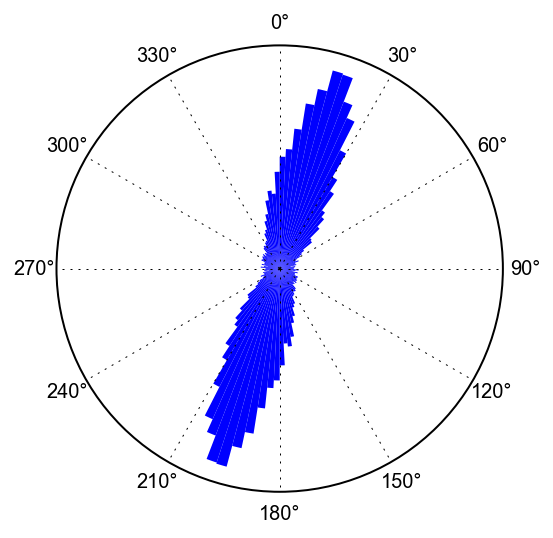

In [89]:
#plt.subplot(111, polar=True)
#rose(keeps.theta, bidirectional=True, bins=120, lw=0)
#plt.gca().set_yticks([])
#plt.gca().set_xticks(np.radians(np.arange(12) * 30))
#plt.show()

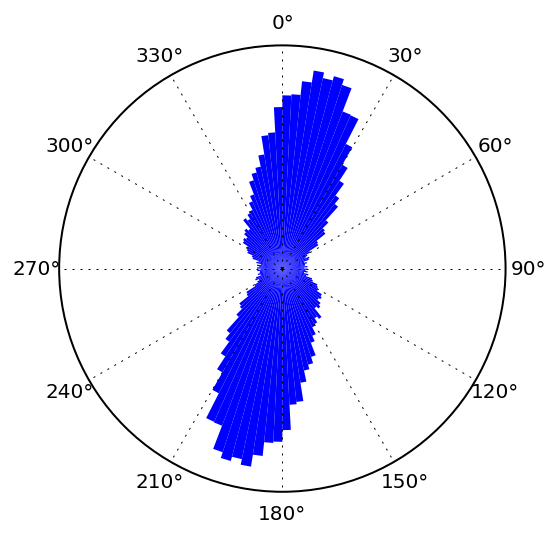

In [18]:
plt.subplot(111, polar=True)
rose(keeps.theta, bidirectional=True, bins=120, lw=0)
plt.gca().set_yticks([])
plt.gca().set_xticks(np.radians(np.arange(12) * 30))
plt.show()

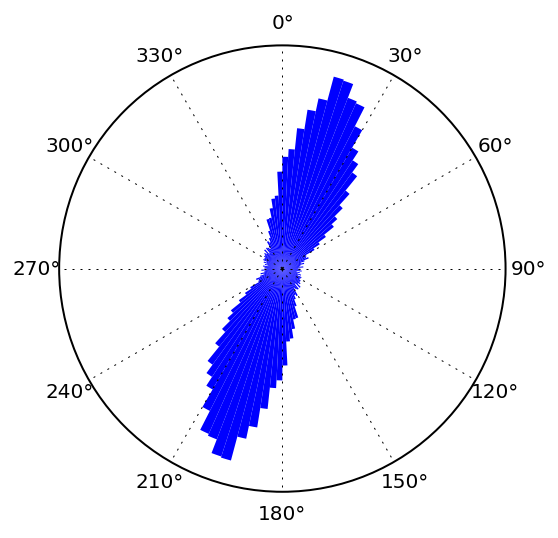

In [30]:
plt.subplot(111, polar=True)
rose(keeps.theta, bidirectional=True, bins=120, lw=0)
plt.gca().set_yticks([])
plt.gca().set_xticks(np.radians(np.arange(12) * 30))
plt.show()

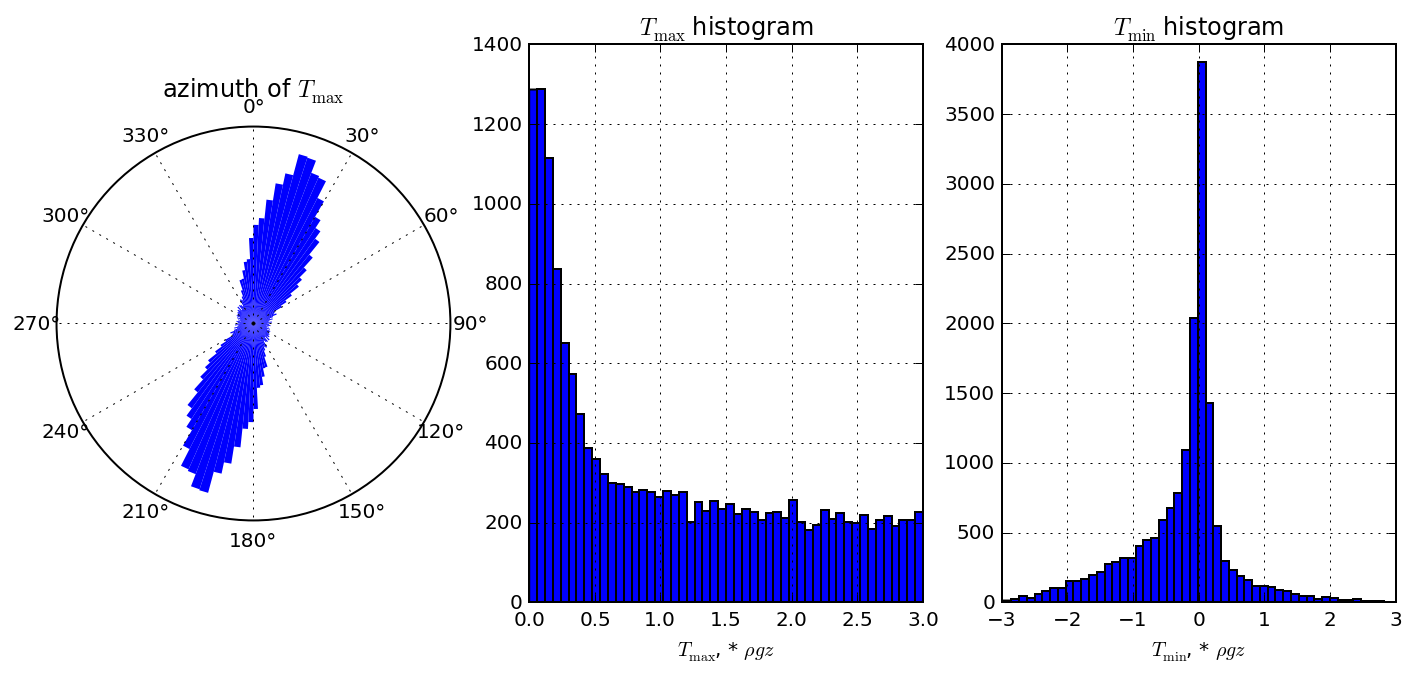

In [29]:
plt.figure(figsize=(12,5))

plt.subplot(131, polar=True)
rose(keeps.theta, bidirectional=True, bins=120, lw=0)
plt.gca().set_yticks([])
plt.gca().set_xticks(np.radians(np.arange(12) * 30))
plt.title(r'azimuth of $T_{\max}$')

plt.subplot(132)
keeps.s1.hist(bins=50)
plt.title(r'$T_{\max}$ histogram')
plt.xlabel(r'$T_{\max}$, * $\rho g z$')

plt.subplot(133)
keeps.s3.hist(bins=50)
plt.title(r'$T_{\min}$ histogram')
plt.xlabel(r'$T_{\min}$, * $\rho g z$')

plt.show()

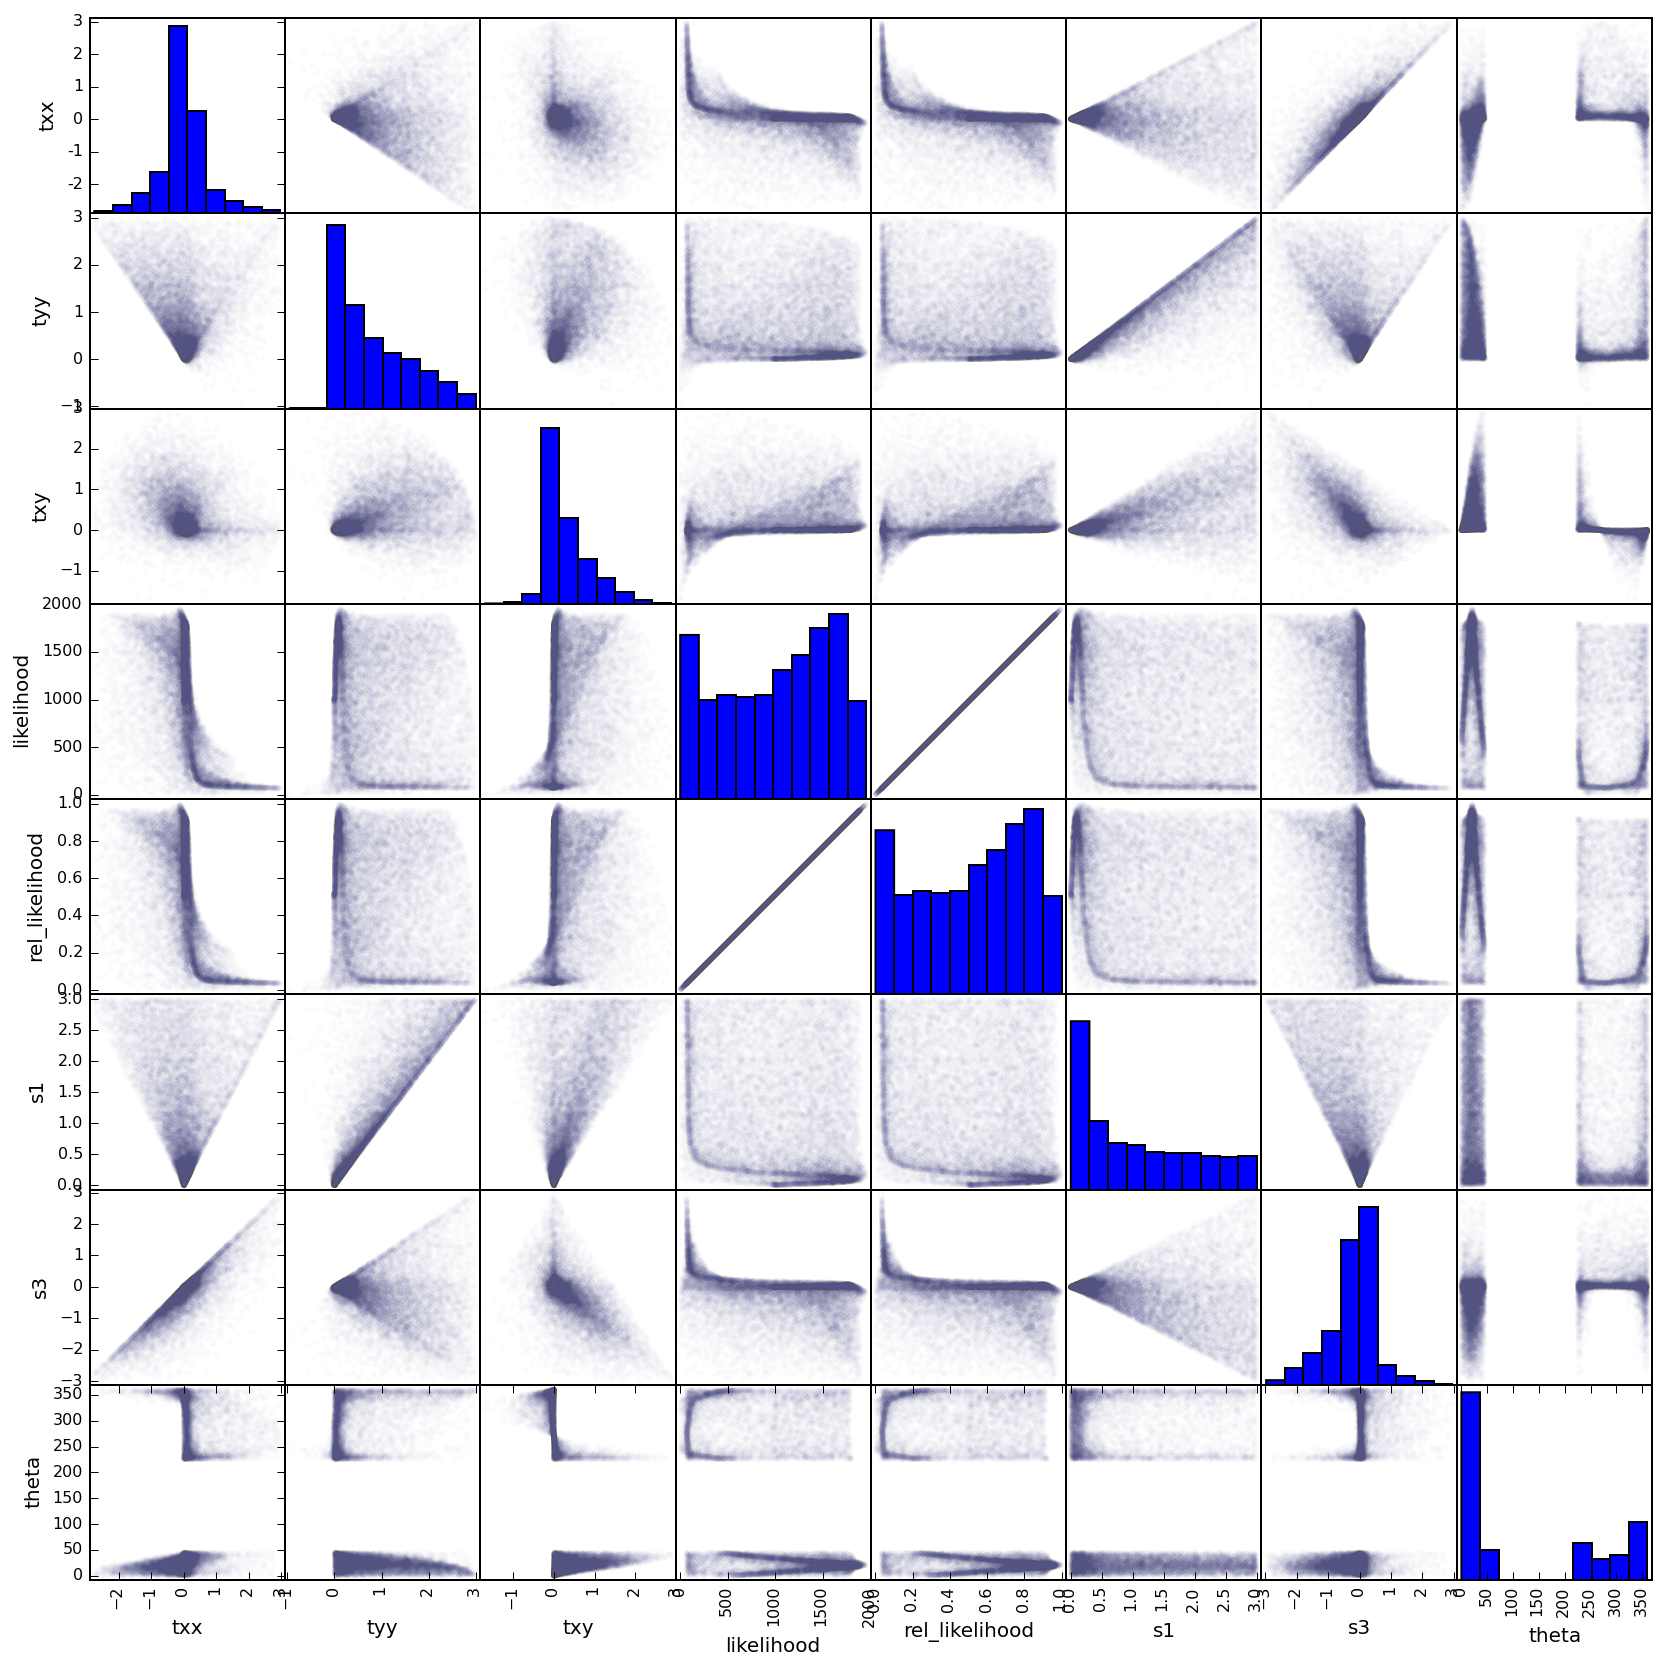

In [31]:
pd.tools.plotting.scatter_matrix(keeps, alpha=0.01, figsize=(14,14))

plt.show()

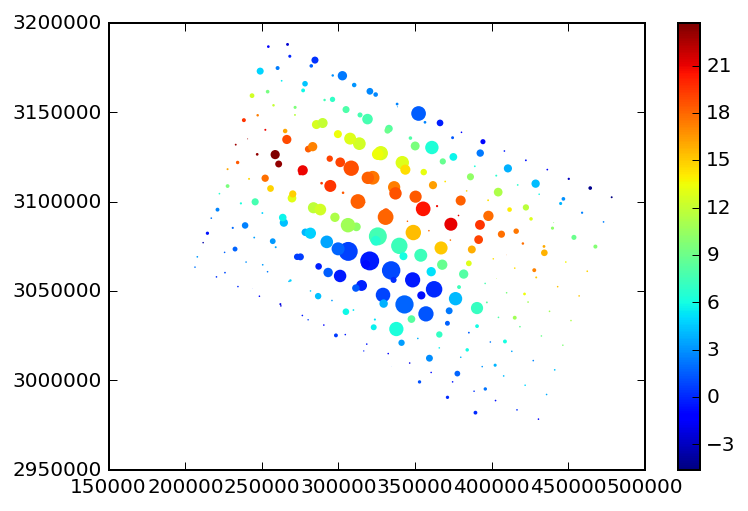

In [32]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].tau_dd,
            s=fdf[fdf.dip==10].slip_m*20,
            lw=0)
plt.colorbar()

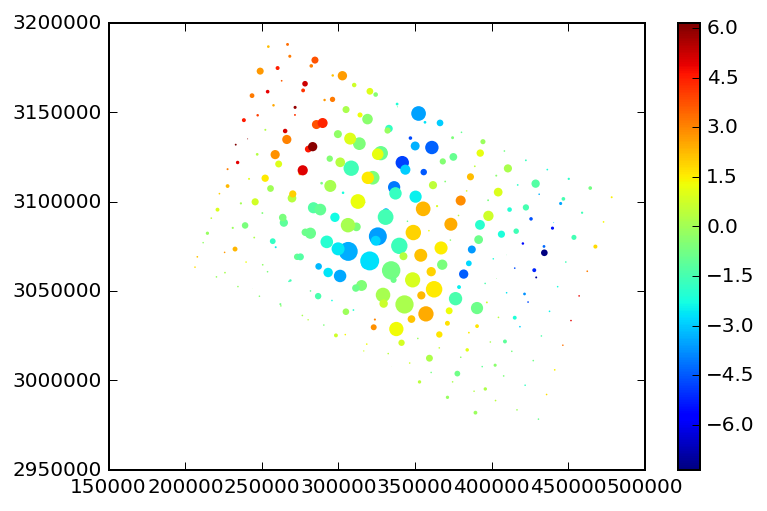

In [33]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].tau_ss,
            s=fdf[fdf.dip==10].slip_m*20,
            lw=0)
plt.colorbar()

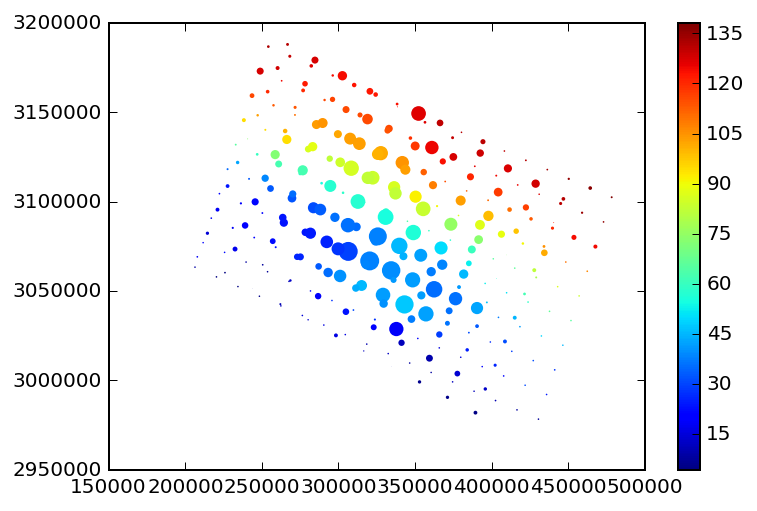

In [34]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].sig_nn,
            s=fdf[fdf.dip==10].slip_m*20,
            lw=0)
plt.colorbar()

In [35]:
mht = fdf[fdf.dip==10]

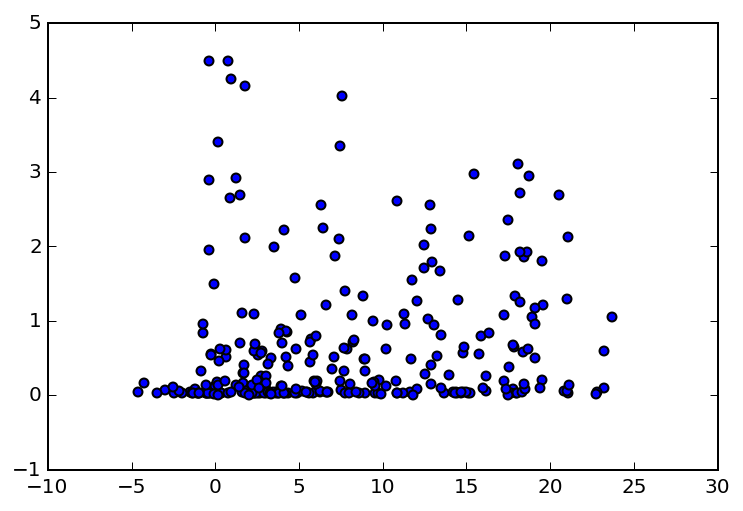

In [36]:
plt.scatter(mht.tau_dd, mht.slip_m)

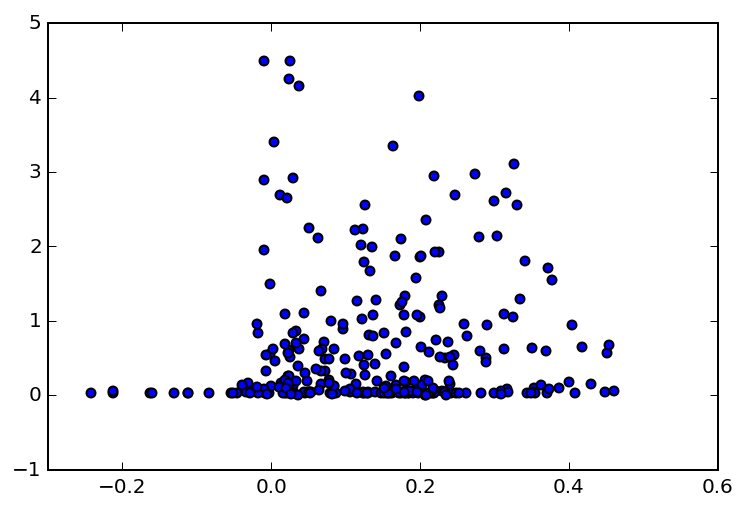

In [37]:
plt.scatter(mht.tau_dd/mht.sig_nn, mht.slip_m)

In [69]:
fdf.slip_m.describe()

count    1044.000000
mean        0.163052
std         0.296784
min         0.001200
25%         0.100000
50%         0.100000
75%         0.100000
max         3.106400
dtype: float64

In [38]:
keeps.head()

,txx,tyy,txy,likelihood,rel_likelihood,s1,s3,theta
iter,,,,,,,,
2,0.854166,0.373771,0.364815,157.759374,0.080634,1.050758,0.177180,241.680648
7,0.151238,0.145395,0.026907,1527.548470,0.780758,0.175382,0.121251,228.098413
28,-0.124724,0.999307,0.089178,834.695836,0.426628,1.006339,-0.131756,4.508137
32,-0.235468,1.946324,0.465035,1035.574922,0.529301,2.041308,-0.330452,11.543969
33,-0.076914,1.142021,-0.198089,380.150747,0.194302,1.173404,-0.108297,350.997412


In [39]:
keeps.to_csv('../results/T_results.csv')